# Heart Attack Analysis - Permutation-based Variable Importance

---


## Task

For the selected dataset and models, prepare a knitr/jupyter notebook based on the following points (you can reuse models from previous Homeworks).
Submit your results on GitHub to the directory `Homeworks/HW5`.

0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.
1. Calculate Permutation-based Variable Importance for the selected model.
2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?
3. For the tree-based model from (1), compare PVI with: 
    - A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the `feature_importances_` attribute in `xgboost` and `sklearn`.
    - B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the `shap` package. 
    
    What are the differences? Why?
4. ! COMMENT on the results obtained in (1)-(3)



## 1. Calculate Permutation-based Variable Importance for the selected model.

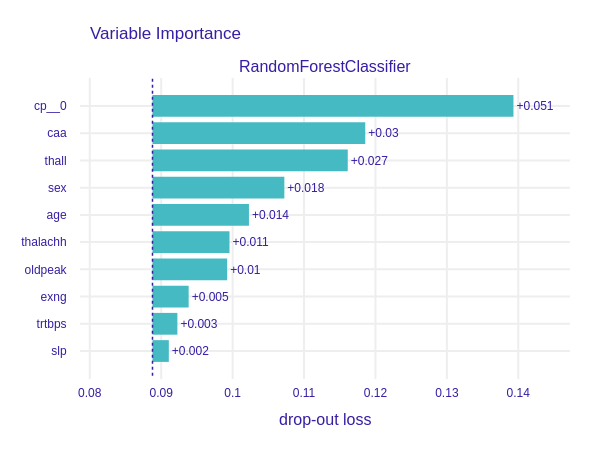

It looks like `cp__0`, `caa`, and `thall` are the most important features for the model. It is hard to compare to previous homeworks since we did mostly local explanations there, and the above plot can tell us only about global feature importance. If we look at PDP plots from the previous homework, for the same model, we see that all the most important variables have a large contribution to the model response.

# 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

We train 3 classifiers: XGBoost, LightGBM and Catboost and plot variable importance below, respectively:

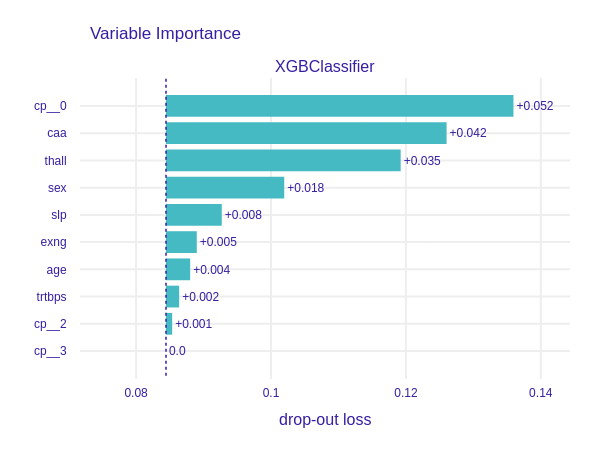



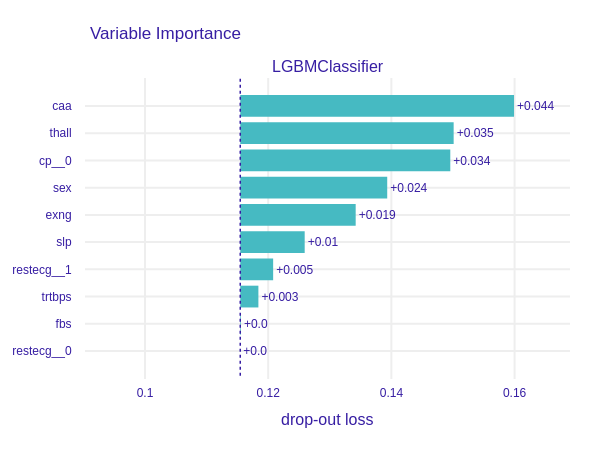

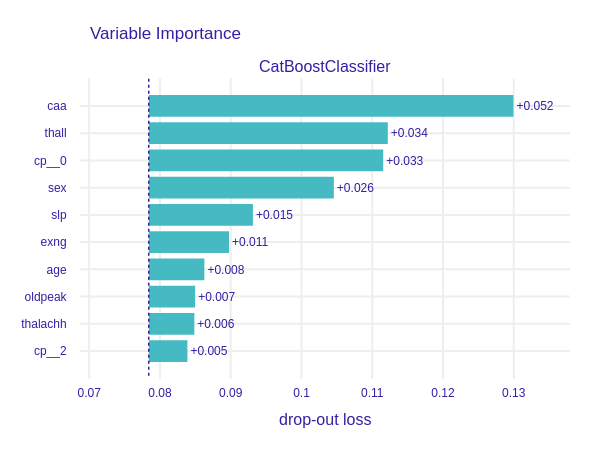

We trained 3 gradient boosting models with similar performance and noted the following observations:


*   Top3 most important features are the same for all the models, including the original random forest.
*   However, the order of these features is permuted almost all the time - for instance the CatBoost model has $+0.052$ loss for permuting variable `caa` and only $+0.033$ for `cp__0`, whereas the original random forest model has almost the inverse situation - `cp__0` has $+0.05$ and `caa` $+0.03$. 
*   Some models rely on a smaller number of features, especially the LGBM one which has non-zero dropout loss change only for 8 variables.

Even though all compared models are gradient boosting models, it is not surprising to see these differences to that extent - each model has completely different hyperparameters and could fit the data in a slightly different way. 



## 3. For the tree-based model from (1), compare PVI with: 

    

### A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the `feature_importances_` attribute in `xgboost` and `sklearn`.

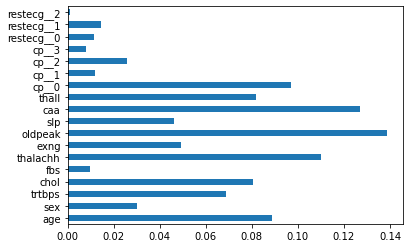

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=test_ds.columns)
feat_importances.plot(kind='barh')

There are notable differences between feature importances from sklearn and permutation based importance:

*   Variable `oldpeak` gets the biggest importance according to sklearn, yet it is much less important according to the permutation-based importance. Similar for the variable `thalachh`. 
*   Top variables from the permutation-based importance have also large importance in sklearn

One difference is that sklearn feature importance is computed based on the training set, which has following consequences:


*   The size of the train dataset is much larger than the test set, so there is less noise in feature importances.
*   However, train set importances might not transfer well to the test set.

Importances in sklearn are based on mean decrease in impurity within each tree. In sklearn [documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) we read that this way of calculating importance has numerous limitations like inflating importance of numerical variables. This is probably the reason why numerical variables `oldpeak` and `thalachh` got so much importance which isn't justified by the permutation based method.



### B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the `shap` package.



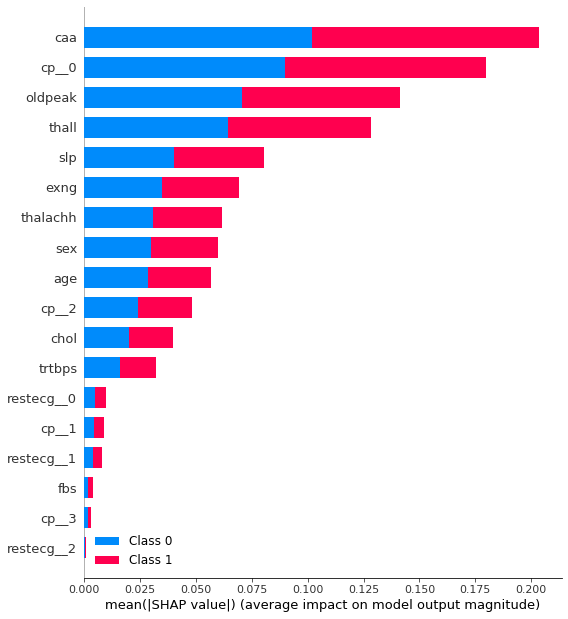

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_ds)
shap.summary_plot(shap_values, test_ds, plot_type="bar")

Importances calculated by TreeSHAP look much closer to those generated by the permutation-based method. In top4 important features, 3 of them: `caa`, `cp__0`, `thall` are top3 features according to the permutation method. The `oldpeak` variable which is the most important according to the sklearn, is top3 in SHAP and top7 in permutation importance. 

In general, the SHAP importance gives further support for credibility of the permutation approach, being much closer to it than the sklearn importance suffering from issues mentioned above.

# Appendix

In [1]:
# Download the dataset
!gdown --id 1NZWMlrVLLFcpeUxIUK8b5gG3DZ0qN3C2
!unzip heart_attack.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1NZWMlrVLLFcpeUxIUK8b5gG3DZ0qN3C2
To: /content/heart_attack.zip
100% 4.21k/4.21k [00:00<00:00, 4.83MB/s]
Archive:  heart_attack.zip
  inflating: heart.csv               
  inflating: o2Saturation.csv        


In [2]:
!pip install dalex
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 3.8 MB/s 
  Created wheel for dalex: filename=dalex-1.5.0-py3-none-any.whl size=1043321 sha256=2c6f7dcc031c180990c0aa7811ae863e1ae80a4bafe83e663846a774a9f95f7a
  Stored in directory: /root/.cache/pip/wheels/76/31/8c/c78df586df31b3f3e0c4ecc759ee73e175545cff5548201996
Successfully built dalex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 3.8 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import plot_roc_curve

# Initial eyeballing over the data

We look at total number of examples (303) and also investigate balance of positive/negative class.

In [4]:
ds = pd.read_csv('heart.csv')
print('Number of examples: ', len(ds))
ds.head()

Number of examples:  303


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Class balance

We can see that classes are pretty balanced so we don't have to apply any specific techniques for that

In [5]:
ds.output.value_counts()

1    165
0    138
Name: output, dtype: int64

# Variables description

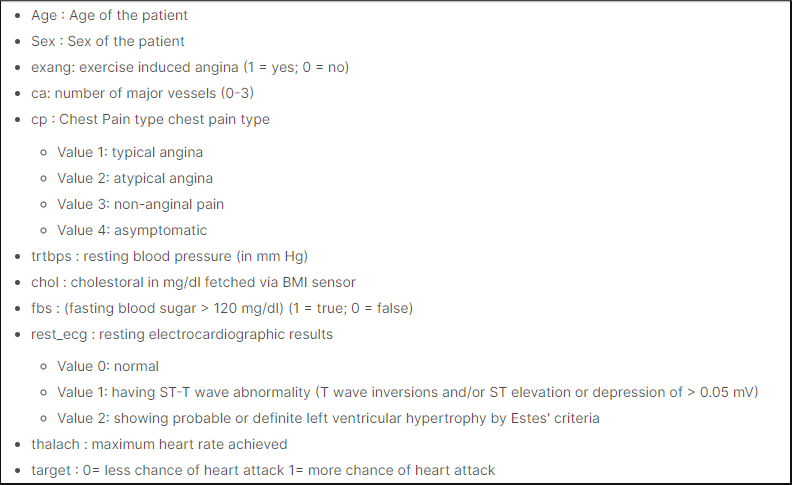

# Data preprocessing

We apply log transform to the numerical variables (so that they are more friendly for logistic regression-type models) and one-hot encoding for categorical variables.

In [6]:
continuous_cols = ['age', 'chol','oldpeak', 'thalachh', 'trtbps']
categorical_cols = ['cp', 'restecg']

def categoricalize(df, columns):
    for col in columns:
        dummy_values = pd.get_dummies(df[col])
        for v in dummy_values.columns:
            df = pd.concat([df, dummy_values[v].rename(f'{col}__{v}')], axis=1)
    return df.drop(columns=columns)

processed_ds = categoricalize(ds, categorical_cols)

for col in continuous_cols:
    processed_ds[col] = np.log1p(ds[col])

x, y = processed_ds.drop(columns=['output']), processed_ds['output']

x_train, x_test, y_train, y_test=train_test_split(x, y,
                                               test_size=0.2,
                                               random_state=2139) 


train_ds = x_train
test_ds = x_test

# Metrics

For the binary classification we measure the following metrics:


*   Accuracy
*   Precision
*   Recall
*   F1
*   MSE

and also plot the confusion matrix



In [7]:
def compute_metrics(y_pred, y_gt):
    cm=confusion_matrix(y_gt, y_pred)
    class_label = ["Low-risk", "High-risk"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm,annot=True,cmap='Pastel1',linewidths=2,fmt='d')
    plt.title("Confusion Matrix",fontsize=15)
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

    acc=accuracy_score(y_gt,y_pred)
    mse=mean_squared_error(y_gt,y_pred)
    precision, recall, fscore, train_support = score(y_gt, y_pred, pos_label=1, average='binary')
    print('Precision: {} \nRecall: {} \nF1: {} \nAccuracy: {} %\nMSE: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore,3), round((acc*100),3), round((mse),3)))

def train_and_evaluate_model(model):
    model.fit(train_ds, y_train)
    y_pred = model.predict(test_ds)

    compute_metrics(y_pred, y_test)
    plot_roc_curve(model, test_ds, y_test)
    return model

## 0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.

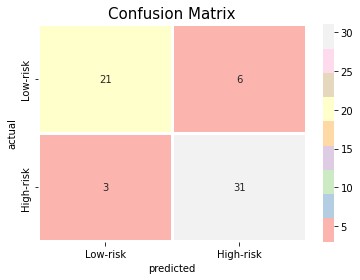

Precision: 0.838 
Recall: 0.912 
F1: 0.873 
Accuracy: 85.246 %
MSE: 0.148


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


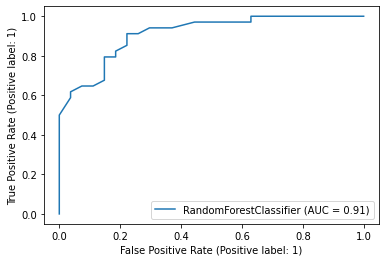

In [8]:
# Fix the rng
np.random.seed(2137)

model = train_and_evaluate_model(RandomForestClassifier(random_state=69))

## 1. Calculate Permutation-based Variable Importance for the selected model.

In [24]:
import dalex as dx 

def get_pvi_for_model(model):
    explainer = dx.Explainer(model, test_ds, y_test, verbose=False)

    return explainer.model_parts(random_state=0)

In [31]:
pvi = get_pvi_for_model(model)
pvi.plot(show=False).update_layout(autosize=False, width=600, height=450)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



It looks like `cp__0`, `caa`, and `thall` are the most important features for the model. It is hard to compare to previous homeworks since we did mostly local explanations there, and the above plot can tell us only about global feature importance. If we look at PDP plots from the previous homework, for the same model, we see that all the most important variables have a large contribution to the model response.

# 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

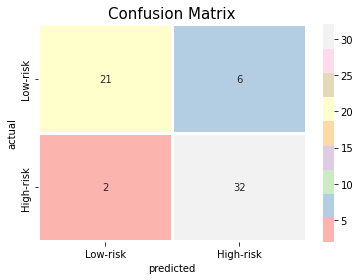

Precision: 0.842 
Recall: 0.941 
F1: 0.889 
Accuracy: 86.885 %
MSE: 0.131


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



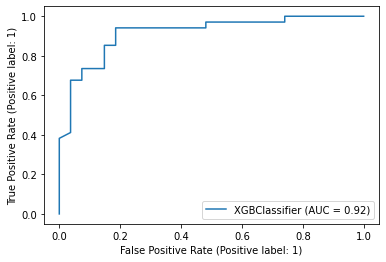

In [40]:
from xgboost import XGBClassifier

xgb_model = train_and_evaluate_model(
    XGBClassifier(n_estimators=100, max_depth=1)
)

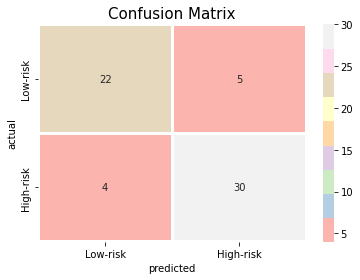

Precision: 0.857 
Recall: 0.882 
F1: 0.87 
Accuracy: 85.246 %
MSE: 0.148


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



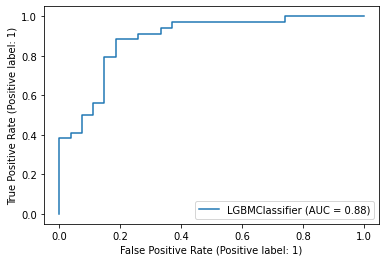

In [53]:
from lightgbm import LGBMClassifier

lgbm_model = train_and_evaluate_model(
    LGBMClassifier(n_estimators=100, max_depth=3, random_state=69)
)

In [55]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


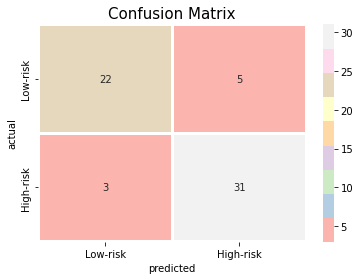

Precision: 0.861 
Recall: 0.912 
F1: 0.886 
Accuracy: 86.885 %
MSE: 0.131


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



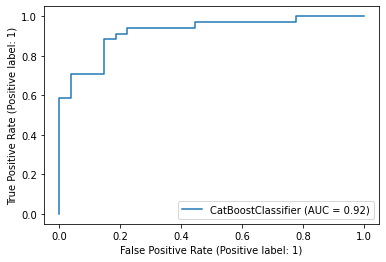

In [58]:
from catboost import CatBoostClassifier

catboost_model = train_and_evaluate_model(
    CatBoostClassifier(verbose=False)
)

In [59]:
pvi_xgb = get_pvi_for_model(xgb_model)
pvi_xgb.plot(show=False).update_layout(autosize=False, width=600, height=450)

In [60]:
pvi_lgbm = get_pvi_for_model(lgbm_model)
pvi_lgbm.plot(show=False).update_layout(autosize=False, width=600, height=450)

In [61]:
pvi_cb = get_pvi_for_model(catboost_model)
pvi_cb.plot(show=False).update_layout(autosize=False, width=600, height=450)

We trained 3 gradient boosting models with similar performance and noted the following observations:


*   Top3 most important features are the same for all the models, including original random forest.
*   However, the order of these features is permuted almost all the time - for instance the CatBoost model has $+0.052$ loss for permuting variable `caa` and only $+0.033$ for `cp__0`, whereas the original random forest model has almost the inverse situation - `cp__0` has $+0.05$ and `caa` $+0.03$. 
*   Some models rely on a smaller number of features, especially the LGBM one which has non-zero dropout loss change only for 8 variables.

Even though all compared models are gradient boosting models, it is not surprising to see these differences to that extent - each model has completely different hyperparameters and could fit the data in a slightly different way. 



## 3. For the tree-based model from (1), compare PVI with: 

    

### A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the `feature_importances_` attribute in `xgboost` and `sklearn`.

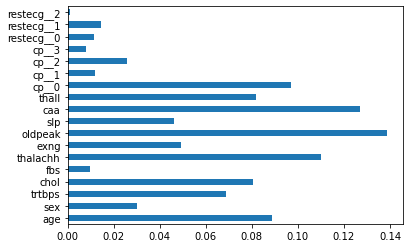

In [64]:
feat_importances = pd.Series(model.feature_importances_, index=test_ds.columns)
feat_importances.plot(kind='barh')

There are notable differences between feature importances from sklearn and permutation based importance:

*   Variable `oldpeak` gets the biggest importance according to sklearn, yet it is much less important according to the permutation-based importance. Similar for the variable `thalachh`. 
*   Top variables from the permutation-based importance have also large importance in sklearn

One difference is that sklearn feature importance is computed based on the training set, which has following consequences:


*   The size of the train dataset is much larger than the test set, so there is less noise in feature importances.
*   However, train set importances might not transfer well to the test set.

Importances in sklearn are based on mean decrease in impurity within each tree. In sklearn [documentation](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html) we read that this way of calculating importance has numerous limitations like inflating importance of numerical variables. This is probably the reason why numerical variables `oldpeak` and `thalachh` got so much importance which isn't justified by the permutation based method.



### B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the `shap` package.



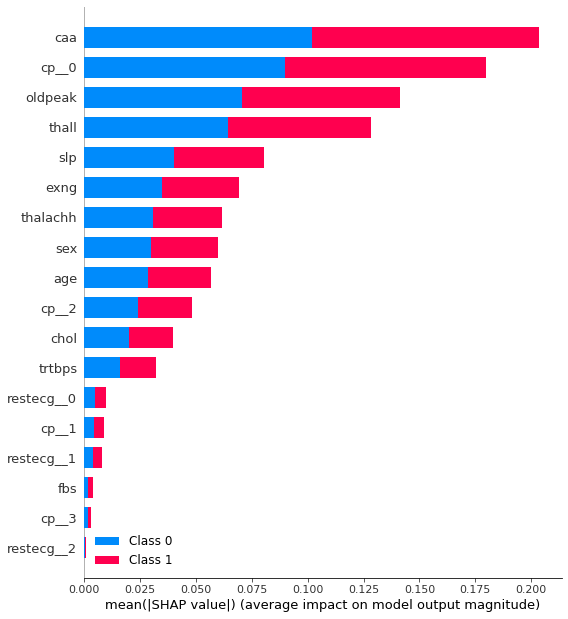

In [68]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_ds)
shap.summary_plot(shap_values, test_ds, plot_type="bar")

Importances calculated by TreeSHAP look much closer to those generated by the permutation-based method. In top4 important features, 3 of them: `caa`, `cp__0`, `thall` are top3 features according to the permutation method. The `oldpeak` variable which is the most important according to the sklearn, is top3 in SHAP and top7 in permutation importance. 

In general, the SHAP importance gives further support for credibility of the permutation approach, being much closer to it than the sklearn importance suffering from issues mentioned above.

In [ ]:
!jupyter nbconvert --to=html xai_hw5_st.ipynb

[NbConvertApp] Converting notebook xai_hw4_st.ipynb to html
[NbConvertApp] Writing 4106990 bytes to xai_hw4_st.html
